- Author: Peter Riesebos
- Purpose: Script used to compare SRP129004 vcf's based on changing filter critera, cr (call rate) and dp (combined depth across samples) with a fixed maf (minor allele frequency) to 1000 genomes vcf.
- Input: plink2 format .frq files from two datasets (SRP129004 and 1000 genomes)
- Output: variant count graph for each dp cr combo and a correlation graph

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
print("imports done")

imports done


In [2]:
# Directory containing the files
directory = "/scratch/hb-functionalgenomics/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/SRP129004/filter_comparison_fixed_maf/fixed_freq/"

# List all files in the directory
files = os.listdir(directory)

# Filter out only the .frq files
frq_files = [file for file in files if file.endswith(".frq")]

# Loop through each file and load into a uniquely named dataframe
dataframes = {}
for file in frq_files:
    # Generate a unique dataframe name based on the file name
    dataframe_name = os.path.splitext(os.path.splitext(file)[0])[0]  # Remove the last extension
    dataframe_name = dataframe_name.replace("_output", "")  # Remove '_output' part
    dataframe_name = dataframe_name.replace(".vcf", "")  # Remove '.vcf' part
    # Read the file into a dataframe
    file_path = os.path.join(directory, file)
    dataframes[dataframe_name] = pd.read_csv(file_path, sep='\s+')

In [3]:
print(dataframes.keys())

dict_keys(['cr_0.7_dp_4', 'cr_0.4_dp_4', 'cr_0.5_dp_1', 'cr_1.0_dp_5', 'cr_0.5_dp_7', 'cr_1.0_dp_10', 'cr_0.3_dp_9', 'cr_0.3_dp_1', 'cr_1.0_dp_4', 'cr_0.6_dp_3', 'cr_0.7_dp_3', 'cr_0.1_dp_3', 'cr_0.2_dp_5', 'cr_0.8_dp_10', 'cr_0.4_dp_7', 'cr_0.1_dp_8', 'cr_0.5_dp_9', 'cr_0.5_dp_2', 'cr_0.2_dp_2', 'cr_0.4_dp_3', 'cr_0.1_dp_4', 'cr_0.2_dp_9', 'cr_0.7_dp_7', 'cr_0.1_dp_1', 'cr_0.3_dp_3', 'cr_1.0_dp_1', 'cr_0.5_dp_3', 'cr_0.4_dp_8', 'cr_0.3_dp_5', 'cr_0.9_dp_8', 'cr_0.4_dp_9', 'cr_0.6_dp_7', 'cr_0.9_dp_9', 'cr_0.6_dp_1', 'cr_0.4_dp_6', 'cr_0.9_dp_4', 'cr_0.1_dp_5', 'cr_1.0_dp_3', 'cr_0.8_dp_7', 'cr_0.9_dp_5', 'cr_0.3_dp_8', 'cr_0.8_dp_4', 'cr_0.6_dp_5', 'cr_0.8_dp_5', 'cr_0.2_dp_7', 'cr_0.9_dp_7', 'cr_0.4_dp_5', 'cr_0.8_dp_3', 'cr_1.0_dp_8', 'cr_0.5_dp_4', 'cr_0.6_dp_10', 'cr_0.6_dp_6', 'cr_0.8_dp_6', 'cr_0.7_dp_9', 'cr_0.1_dp_6', 'cr_1.0_dp_9', 'cr_0.4_dp_2', 'cr_0.6_dp_2', 'cr_1.0_dp_2', 'cr_0.4_dp_1', 'cr_0.5_dp_8', 'cr_0.7_dp_1', 'cr_0.9_dp_10', 'cr_1.0_dp_6', 'cr_0.3_dp_2', 'cr_0.7_dp

In [3]:
thousandg = pd.read_csv("/scratch/hb-functionalgenomics/projects/gut-bulk/reference/1000g_HJ/eur_allele_freq_1000g.frq", sep='\s+')

In [6]:
thousandg.head(5)

,CHR,SNP,A1,A2,MAF,NCHROBS
0,1,1:10390:CCCCTAACCC:C,C,CCCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA,0.015900,1006
1,1,1:10399:C:A,A,C,0.000000,1006
2,1,1:10398:C:CCCCTAA,CCCCTAA,C,0.005964,1006
3,1,1:10397:CCCCTAA:C,C,CCCCTAA,0.018890,1006
4,1,1:10403:A:ACCCTAACCC,ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC,A,0.004970,1006


In [4]:
maf_filtered_thousandg = thousandg[thousandg['MAF'] >= 0.01]
maf_filtered_thousandg.head(5)

,CHR,SNP,A1,A2,MAF,NCHROBS
0,1,1:10390:CCCCTAACCC:C,C,CCCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA,0.01590,1006
3,1,1:10397:CCCCTAA:C,C,CCCCTAA,0.01889,1006
42,1,1:10583:G:A,A,G,0.04473,1006
52,1,1:13417:C:CGAGA,CGAGA,C,0.16200,1006
63,1,1:13649:G:C,C,G,0.08449,1006


In [5]:
print(thousandg.shape, maf_filtered_thousandg.shape)

(70692015, 6) (11278251, 6)


In [12]:
# Dictionary to hold merged dataframes
merged_dataframes = {}

# Perform merge for each dataframe in the dataframes dictionary
for name, df in dataframes.items():
    merged_df = pd.merge(thousandg, df, on=['SNP'], suffixes=('_MAF1', '_MAF2'))
    merged_dataframes[name] = merged_df
    
merged_df.head(3)

,CHR_MAF1,SNP,A1_MAF1,A2_MAF1,MAF_MAF1,NCHROBS_MAF1,CHR_MAF2,A1_MAF2,A2_MAF2,MAF_MAF2,NCHROBS_MAF2
0,1,1:14671:G:C,C,G,0.009940,1006,1,C,G,0.007653,392
1,1,1:14773:C:T,T,C,0.014910,1006,1,T,C,0.002525,396
2,1,1:14775:C:T,T,C,0.000994,1006,1,T,C,0.007500,400


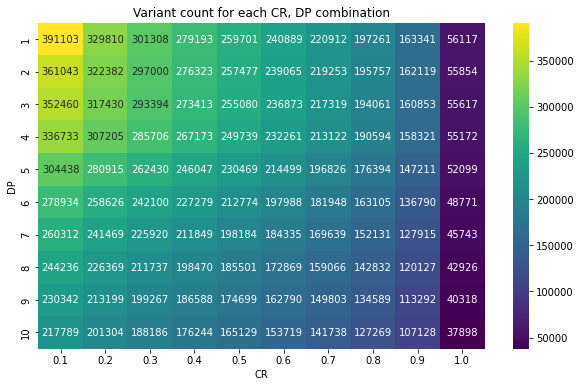

In [41]:
# Generate unique combinations of 'cr' and 'dp' values to ensure 10x10 heatmap
cr_values = np.linspace(0.1, 1.0, 10)
dp_values = np.arange(1, 11)

# Initialize a 10x10 matrix to store the size of the 'SNP' column for each dataframe
heatmap_matrix_count = np.zeros((10, 10))

# Iterate through dataframe names, extract cr and dp values, and update heatmap_matrix
for df_name, df in merged_dataframes.items():
    cr = float(df_name.split('_')[1])
    dp = int(df_name.split('_')[3])
    cr_index = round((cr - 0.1) / 0.1)
    dp_index = dp - 1

    # Get the size of the 'SNP' column and assign it to the corresponding position in the heatmap matrix
    heatmap_matrix_count[dp_index, cr_index] = df['SNP'].size

# Plot the heatmap
plt.figure(figsize=(10, 6), facecolor='white')
sns.heatmap(heatmap_matrix_count, cmap='viridis', annot=True, fmt='g')

plt.xticks(np.arange(len(cr_values)) + 0.5, [f'{cr:.1f}' for cr in cr_values])
plt.yticks(np.arange(len(dp_values)) + 0.5, dp_values)

plt.xlabel('CR')
plt.ylabel('DP')
plt.title('Variant count for each CR, DP combination')
plt.show()

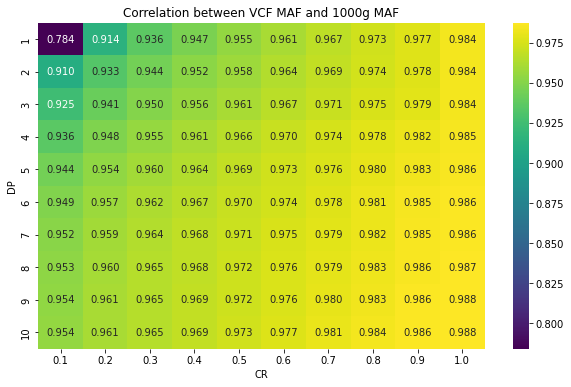

In [36]:
# Generate unique combinations of 'cr' and 'dp' values to ensure 10x10 heatmap
cr_values = np.linspace(0.1, 1.0, 10)
dp_values = np.arange(1, 11)

# Initialize a 10x10 matrix to store the size of the 'SNP' column for each dataframe
heatmap_matrix_correlation = np.zeros((10, 10))

# Iterate through dataframe names, extract cr and dp values, and update heatmap_matrix
for df_name, df in merged_dataframes.items():
    cr = float(df_name.split('_')[1])
    dp = int(df_name.split('_')[3])
    cr_index = round((cr - 0.1) / 0.1)
    dp_index = dp - 1

    # Calculate correlation coefficient between 'MAF_MAF1' and 'MAF_MAF2' columns
    correlation_coefficient = df['MAF_MAF1'].corr(df['MAF_MAF2'])

    # Update the heatmap matrix with the correlation coefficient
    heatmap_matrix_correlation[dp_index, cr_index] = correlation_coefficient

# Plot the heatmap
plt.figure(figsize=(10, 6), facecolor='white')
sns.heatmap(heatmap_matrix_correlation, cmap='viridis', annot=True, fmt='.3f')

plt.xticks(np.arange(len(cr_values)) + 0.5, [f'{cr:.1f}' for cr in cr_values])
plt.yticks(np.arange(len(dp_values)) + 0.5, dp_values)

plt.xlabel('CR')
plt.ylabel('DP')
plt.title('Correlation between VCF MAF and 1000g MAF')
plt.show()